In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

# Answers will be stored here

In [2]:
# (algo, dataset, trial, metric)
training_algo_data_all_metrics = np.zeros((3,4,5,3))

# (depth, row, column)
# (algo, dataset, mean metric)
training_algo_data_mean_metrics = np.zeros((3,4,3))

# (algo, dataset, trial, metric)
algo_data_all_metrics = np.zeros((3,4,5,3))

# (depth, row, column)
# (algo, dataset, mean metric)
algo_data_mean_metrics = np.zeros((3,4,3))

## Adult Dataset

age: continuous. 
workclass: 8 (remove 1 after filtering)
fnlwgt: continuous. 
education: 16 
education-num: continuous. 
marital-status: 7
occupation: 14 
relationship: 6 
race: 5 
sex: 2 
capital-gain: continuous. 
capital-loss: continuous. 
hours-per-week: continuous. 
native-country: 41

In [3]:
col = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
        'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
adult = pd.read_csv('adult.data', names=col, skipinitialspace=True)
adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
# cleaning
adult['income'].replace({'<=50K': 0, '>50K': 1}, inplace=True)
adult = adult[adult['workclass'] != '?']
adult = adult[adult['occupation'] != '?']
adult = adult[adult['native-country'] != '?']

(array([22654.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  7508.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

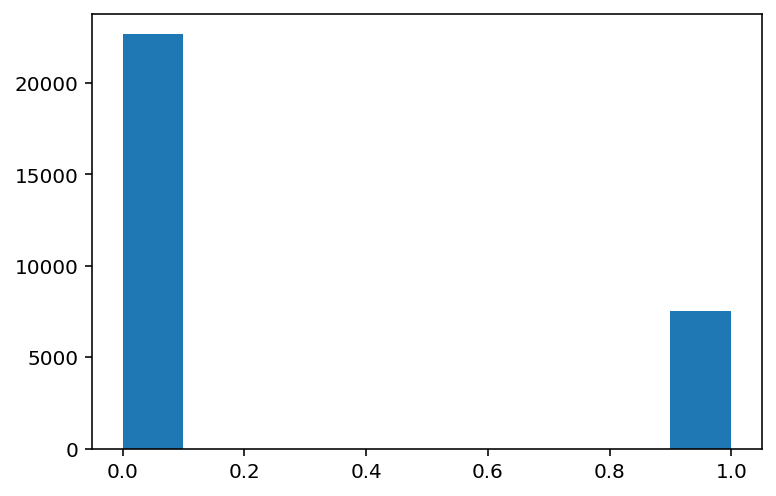

In [5]:
df = adult
plt.hist(df['income'])

In [6]:
df['income'].value_counts()

0    22654
1     7508
Name: income, dtype: int64

### Scale and One-Hot Encode Features

In [7]:
# Import libraries and download example data
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define which columns should be encoded vs scaled
columns_to_encode = ['workclass', 'education', 'marital-status', 'occupation',
                                    'relationship', 'race', 'sex', 'native-country']
columns_to_scale  = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns = scaler.fit_transform(df[columns_to_scale]) 
encoded_columns = ohe.fit_transform(df[columns_to_encode])

y = df['income'].to_numpy()

# Concatenate (Column-Bind) Processed Columns Back Together
X = np.concatenate([scaled_columns, encoded_columns], axis=1)

### GridSearch

In [8]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


trials = 5
scoring = ['accuracy', 'f1_micro', 'roc_auc_ovr']


for trial in range(trials):
    
    scores_train = np.zeros(len(scoring))
    scores_test = np.zeros(len(scoring))

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=5000, 
                                                         stratify=y, shuffle=True)



    # LogReg
    pipe = Pipeline([('classifier', LogisticRegression())])

    search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['saga'],
                     'classifier__penalty': ['l1', 'l2'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['newton-cg','lbfgs','sag'],
                     'classifier__penalty': ['l2'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['liblinear'],
                     'classifier__penalty': ['l1'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['newton-cg','lbfgs','saga','sag'],
                     'classifier__penalty': ['none']}
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)
    

    for i,metric in enumerate(scoring):
        penalty = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__penalty']
        if 'classifier__C' in best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]:
            C = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__C']
        else:
            C = 0
        solver = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__solver']
        clf = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=5000)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test

        
    training_algo_data_all_metrics[0][0][trial] = scores_train
    algo_data_all_metrics[0][0][trial] = scores_test


    # KNN
    pipe = Pipeline([('classifier', KNeighborsClassifier())])

    search_space = [{'classifier': [KNeighborsClassifier()],
                     'classifier__weights': ['uniform','distance'],
                     'classifier__n_neighbors': np.arange(1,105,4)},
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)


    for i,metric in enumerate(scoring):
        weights = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__weights']
        n_neighbors = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__n_neighbors']
        clf = KNeighborsClassifier(weights=weights, n_neighbors=n_neighbors)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test
        
    training_algo_data_all_metrics[1][0][trial] = scores_train
    algo_data_all_metrics[1][0][trial] = scores_test
    
    
    # Random Forest
    pipe = Pipeline([('classifier', RandomForestClassifier())])

    search_space = [{'classifier': [RandomForestClassifier()],
                     'classifier__max_features': [1,2,4,6,8,12,16,20],
                     'classifier__n_estimators': [1024]},
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)

    for i,metric in enumerate(scoring):
        max_features = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__max_features']
        n_estimators = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__n_estimators']
        clf = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test
        
    training_algo_data_all_metrics[2][0][trial] = scores_train
    algo_data_all_metrics[2][0][trial] = scores_test

CPU times: user 6min 27s, sys: 4.31 s, total: 6min 32s
Wall time: 20min 19s


In [9]:
training_algo_data_all_metrics

array([[[[0.8484    , 0.66008969, 0.76242654],
         [0.8532    , 0.6791958 , 0.76711266],
         [0.847     , 0.66284707, 0.76068482],
         [0.8488    , 0.6642984 , 0.75974845],
         [0.8438    , 0.65549184, 0.76124311]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[1.        , 1.        , 0.74879117],
   

In [10]:
algo_data_all_metrics

array([[[[0.84619665, 0.66022827, 0.7640097 ],
         [0.84667356, 0.66446338, 0.76043991],
         [0.84631587, 0.66388527, 0.76083769],
         [0.84504411, 0.66454444, 0.76379805],
         [0.84742866, 0.66047417, 0.76344157]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.83383674, 0.63684531, 0.74211571],
   

## Covtype Dataset

In [11]:
'''
col = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
    'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type', 'Cover_Type' 
]
'''
covtype = pd.read_csv('covtype.data', header=None)#.sample(n=10000)
covtype

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [12]:
# cleaning
covtype[54].replace({1:0, 3:0, 4:0, 5:0, 6:0, 7:0}, inplace=True)
covtype[54].replace({2:1}, inplace=True)

(array([297711.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 283301.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

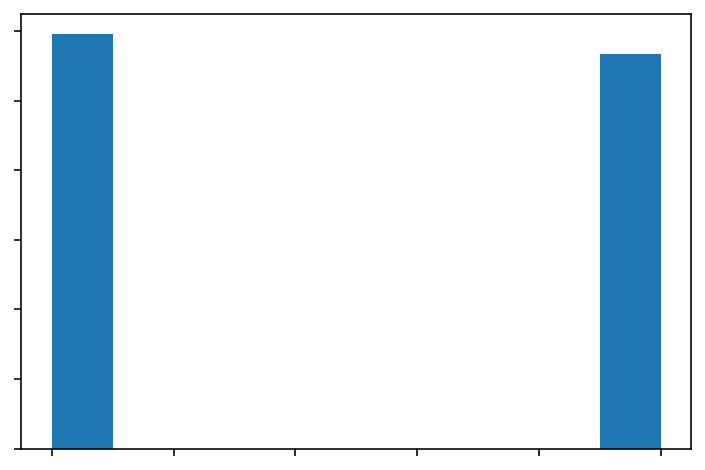

In [13]:
df = covtype
plt.hist(df[54])

In [14]:
df[54].value_counts()

0    297711
1    283301
Name: 54, dtype: int64

### Scale and One-Hot Encode Features

In [15]:
# Import libraries and download example data
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define which columns should be encoded vs scaled
columns_to_encode = range(10, 54)
columns_to_scale  = range(0, 10)

# Instantiate encoder/scaler
scaler = StandardScaler()

# Scale and Encode Separate Columns
scaled_columns = scaler.fit_transform(df[columns_to_scale]) 
encoded_columns = df[columns_to_encode]

y = df[54].to_numpy()

# Concatenate (Column-Bind) Processed Columns Back Together
X = np.concatenate([scaled_columns, encoded_columns], axis=1)

### GridSearch

In [16]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


trials = 5
scoring = ['accuracy', 'f1_micro', 'roc_auc_ovr']


for trial in range(trials):
    
    scores_train = np.zeros(len(scoring))
    scores_test = np.zeros(len(scoring))

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=5000, 
                                                         stratify=y, shuffle=True)



    # LogReg
    pipe = Pipeline([('classifier', LogisticRegression())])

    search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['saga'],
                     'classifier__penalty': ['l1', 'l2'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['newton-cg','lbfgs','sag'],
                     'classifier__penalty': ['l2'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['liblinear'],
                     'classifier__penalty': ['l1'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['newton-cg','lbfgs','saga','sag'],
                     'classifier__penalty': ['none']}
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)
    

    for i,metric in enumerate(scoring):
        penalty = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__penalty']
        if 'classifier__C' in best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]:
            C = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__C']
        else:
            C = 0
        solver = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__solver']
        clf = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=5000)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test

    
    training_algo_data_all_metrics[0][1][trial] = scores_train
    algo_data_all_metrics[0][1][trial] = scores_test


    # KNN
    pipe = Pipeline([('classifier', KNeighborsClassifier())])

    search_space = [{'classifier': [KNeighborsClassifier()],
                     'classifier__weights': ['uniform','distance'],
                     'classifier__n_neighbors': np.arange(1,105,4)},
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)


    for i,metric in enumerate(scoring):
        weights = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__weights']
        n_neighbors = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__n_neighbors']
        clf = KNeighborsClassifier(weights=weights, n_neighbors=n_neighbors)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test
        
    training_algo_data_all_metrics[1][1][trial] = scores_train
    algo_data_all_metrics[1][1][trial] = scores_test
    
    
    # Random Forest
    pipe = Pipeline([('classifier', RandomForestClassifier())])

    search_space = [{'classifier': [RandomForestClassifier()],
                     'classifier__max_features': [1,2,4,6,8,12,16,20],
                     'classifier__n_estimators': [1024]},
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)

    for i,metric in enumerate(scoring):
        max_features = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__max_features']
        n_estimators = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__n_estimators']
        clf = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test
        
    training_algo_data_all_metrics[2][1][trial] = scores_train
    algo_data_all_metrics[2][1][trial] = scores_test

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


CPU times: user 38min 25s, sys: 8.37 s, total: 38min 33s
Wall time: 45min 19s


In [17]:
training_algo_data_all_metrics

array([[[[0.8484    , 0.66008969, 0.76242654],
         [0.8532    , 0.6791958 , 0.76711266],
         [0.847     , 0.66284707, 0.76068482],
         [0.8488    , 0.6642984 , 0.75974845],
         [0.8438    , 0.65549184, 0.76124311]],

        [[0.7518    , 0.750653  , 0.75135796],
         [0.7466    , 0.74665067, 0.75043179],
         [0.744     , 0.74078574, 0.74434532],
         [0.7648    , 0.76328502, 0.7644966 ],
         [0.7576    , 0.75310401, 0.75802974]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[1.        , 1.        , 0.74879117],
   

In [18]:
algo_data_all_metrics

array([[[[0.84619665, 0.66022827, 0.7640097 ],
         [0.84667356, 0.66446338, 0.76043991],
         [0.84631587, 0.66388527, 0.76083769],
         [0.84504411, 0.66454444, 0.76379805],
         [0.84742866, 0.66047417, 0.76344157]],

        [[0.75228815, 0.74993516, 0.75222159],
         [0.74918578, 0.7486473 , 0.75048111],
         [0.75040798, 0.74648295, 0.750498  ],
         [0.75216315, 0.75016932, 0.75246744],
         [0.75465442, 0.7541477 , 0.75511111]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.83383674, 0.63684531, 0.74211571],
   

## Letter Dataset

In [19]:
letter = pd.read_csv('letter-recognition.data', header=None)
letter

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,D,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,C,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,T,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,S,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


In [20]:
import string

# cleaning
pos = [1]*13
neg = [0]*13
label = pos+neg
asci = list(string.ascii_uppercase)

to_replace = dict(zip(asci, label))

letter[0].replace(to_replace, inplace=True)
letter[0].value_counts()

0    10060
1     9940
Name: 0, dtype: int64

(array([10060.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  9940.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

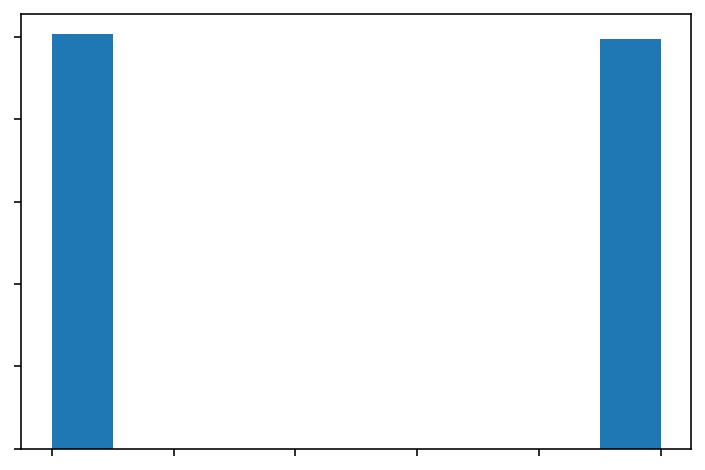

In [21]:
df = letter
plt.hist(df[0])

In [22]:
df[0].value_counts()

0    10060
1     9940
Name: 0, dtype: int64

### Scale Features

In [23]:
# Import libraries and download example data
from sklearn.preprocessing import StandardScaler

# Define which columns should be encoded vs scaled
columns_to_scale  = range(1, 17)

# Instantiate encoder/scaler
scaler = StandardScaler()

# Scale and Encode Separate Columns
scaled_columns = scaler.fit_transform(df[columns_to_scale]) 

y = df[0].to_numpy()

# Concatenate (Column-Bind) Processed Columns Back Together
X = scaled_columns

### GridSearch

In [24]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


trials = 5
scoring = ['accuracy', 'f1_micro', 'roc_auc_ovr']


for trial in range(trials):
    
    scores_train = np.zeros(len(scoring))
    scores_test = np.zeros(len(scoring))

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=5000, 
                                                         stratify=y, shuffle=True)



    # LogReg
    pipe = Pipeline([('classifier', LogisticRegression())])

    search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['saga'],
                     'classifier__penalty': ['l1', 'l2'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['newton-cg','lbfgs','sag'],
                     'classifier__penalty': ['l2'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['liblinear'],
                     'classifier__penalty': ['l1'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['newton-cg','lbfgs','saga','sag'],
                     'classifier__penalty': ['none']}
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)
    

    for i,metric in enumerate(scoring):
        penalty = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__penalty']
        if 'classifier__C' in best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]:
            C = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__C']
        else:
            C = 0
        solver = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__solver']
        clf = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=5000)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test

        
    training_algo_data_all_metrics[0][2][trial] = scores_train
    algo_data_all_metrics[0][2][trial] = scores_test


    # KNN
    pipe = Pipeline([('classifier', KNeighborsClassifier())])

    search_space = [{'classifier': [KNeighborsClassifier()],
                     'classifier__weights': ['uniform','distance'],
                     'classifier__n_neighbors': np.arange(1,105,4)},
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)


    for i,metric in enumerate(scoring):
        weights = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__weights']
        n_neighbors = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__n_neighbors']
        clf = KNeighborsClassifier(weights=weights, n_neighbors=n_neighbors)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test
        
    training_algo_data_all_metrics[1][2][trial] = scores_train
    algo_data_all_metrics[1][2][trial] = scores_test
    
    
    # Random Forest
    pipe = Pipeline([('classifier', RandomForestClassifier())])

    search_space = [{'classifier': [RandomForestClassifier()],
                     'classifier__max_features': [1,2,4,6,8,12,16,20],
                     'classifier__n_estimators': [1024]},
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)

    for i,metric in enumerate(scoring):
        max_features = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__max_features']
        n_estimators = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__n_estimators']
        clf = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test
        
    training_algo_data_all_metrics[2][2][trial] = scores_train
    algo_data_all_metrics[2][2][trial] = scores_test

CPU times: user 1min 45s, sys: 2.32 s, total: 1min 47s
Wall time: 4min 19s


In [25]:
training_algo_data_all_metrics

array([[[[0.8484    , 0.66008969, 0.76242654],
         [0.8532    , 0.6791958 , 0.76711266],
         [0.847     , 0.66284707, 0.76068482],
         [0.8488    , 0.6642984 , 0.75974845],
         [0.8438    , 0.65549184, 0.76124311]],

        [[0.7518    , 0.750653  , 0.75135796],
         [0.7466    , 0.74665067, 0.75043179],
         [0.744     , 0.74078574, 0.74434532],
         [0.7648    , 0.76328502, 0.7644966 ],
         [0.7576    , 0.75310401, 0.75802974]],

        [[0.734     , 0.7369462 , 0.73409123],
         [0.733     , 0.73347974, 0.73405763],
         [0.7136    , 0.71474104, 0.71364969],
         [0.7282    , 0.73051755, 0.72827782],
         [0.731     , 0.734412  , 0.73091751]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[1.        , 1.        , 0.74879117],
   

In [26]:
algo_data_all_metrics

array([[[[0.84619665, 0.66022827, 0.7640097 ],
         [0.84667356, 0.66446338, 0.76043991],
         [0.84631587, 0.66388527, 0.76083769],
         [0.84504411, 0.66454444, 0.76379805],
         [0.84742866, 0.66047417, 0.76344157]],

        [[0.75228815, 0.74993516, 0.75222159],
         [0.74918578, 0.7486473 , 0.75048111],
         [0.75040798, 0.74648295, 0.750498  ],
         [0.75216315, 0.75016932, 0.75246744],
         [0.75465442, 0.7541477 , 0.75511111]],

        [[0.72266667, 0.72337878, 0.72304003],
         [0.72993333, 0.73308295, 0.73023242],
         [0.7242    , 0.72517106, 0.72451315],
         [0.72306667, 0.7219917 , 0.72313657],
         [0.7276    , 0.73228914, 0.72832502]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.83383674, 0.63684531, 0.74211571],
   

## Dota Dataset

1. Team won the game (1 or -1)
2. Cluster ID (related to location)
3. Game mode (eg All Pick)
4. Game type (eg. Ranked)
5 - end: Each element is an indicator for a hero. Value of 1 indicates that a player from team '1' played as that hero and '-1' for the other team. Hero can be selected by only one player each game. This means that each row has five '1' and five '-1' values.

In [27]:
dota = pd.read_csv('dota2Train.csv', header=None)
dota

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,-1,154,2,3,1,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
92646,1,154,2,2,0,0,0,0,-1,0,...,1,0,0,0,0,0,0,0,0,0
92647,1,111,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92648,-1,185,2,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# clean
dota[0].replace({-1:0}, inplace=True)

(array([43868.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 48782.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

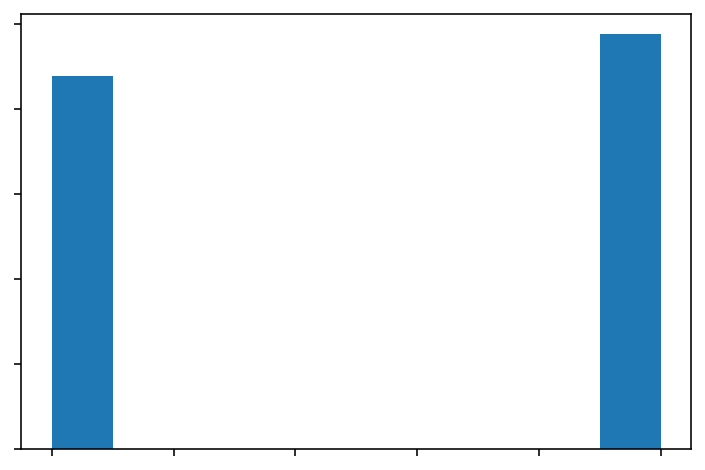

In [29]:
df = dota
plt.hist(df[0])

In [30]:
df[0].value_counts()

1    48782
0    43868
Name: 0, dtype: int64

### Scale and One-Hot Encode Features

In [31]:
# Import libraries and download example data
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define which columns should be encoded vs scaled
columns_to_encode = range(2, 4)
columns_to_scale  = 1

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns = scaler.fit_transform(df[columns_to_scale][:,np.newaxis]) 
encoded_columns = ohe.fit_transform(df[columns_to_encode])

y = df[0].to_numpy()

# Concatenate (Column-Bind) Processed Columns Back Together
X = np.concatenate([scaled_columns, encoded_columns], axis=1)
X = np.concatenate([X, df[range(4, 117)]], axis=1)

In [32]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


trials = 5
scoring = ['accuracy', 'f1_micro', 'roc_auc_ovr']


for trial in range(trials):
    
    scores_train = np.zeros(len(scoring))
    scores_test = np.zeros(len(scoring))

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=5000, 
                                                         stratify=y, shuffle=True)



    # LogReg
    pipe = Pipeline([('classifier', LogisticRegression())])

    search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['saga'],
                     'classifier__penalty': ['l1', 'l2'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['newton-cg','lbfgs','sag'],
                     'classifier__penalty': ['l2'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['liblinear'],
                     'classifier__penalty': ['l1'],
                     'classifier__C': np.logspace(-8, 4, 13)},
                    {'classifier': [LogisticRegression(max_iter=5000)],
                     'classifier__solver': ['newton-cg','lbfgs','saga','sag'],
                     'classifier__penalty': ['none']}
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)
    

    for i,metric in enumerate(scoring):
        penalty = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__penalty']
        if 'classifier__C' in best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]:
            C = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__C']
        else:
            C = 0
        solver = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__solver']
        clf = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=5000)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test

        
    training_algo_data_all_metrics[0][3][trial] = scores_train
    algo_data_all_metrics[0][3][trial] = scores_test


    # KNN
    pipe = Pipeline([('classifier', KNeighborsClassifier())])

    search_space = [{'classifier': [KNeighborsClassifier()],
                     'classifier__weights': ['uniform','distance'],
                     'classifier__n_neighbors': np.arange(1,105,4)},
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)


    for i,metric in enumerate(scoring):
        weights = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__weights']
        n_neighbors = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__n_neighbors']
        clf = KNeighborsClassifier(weights=weights, n_neighbors=n_neighbors)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test
        
    training_algo_data_all_metrics[1][3][trial] = scores_train
    algo_data_all_metrics[1][3][trial] = scores_test
    
    
    # Random Forest
    pipe = Pipeline([('classifier', RandomForestClassifier())])

    search_space = [{'classifier': [RandomForestClassifier()],
                     'classifier__max_features': [1,2,4,6,8,12,16,20],
                     'classifier__n_estimators': [1024]},
                    ]

    clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                       scoring=scoring, refit=False,
                       verbose=0, n_jobs=-1)

    best_model = clf.fit(X_train, y_train)

    for i,metric in enumerate(scoring):
        max_features = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__max_features']
        n_estimators = best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_'+metric]) ]['classifier__n_estimators']
        clf = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators)
        
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        if i == 0:
            score_train = accuracy_score(y_train, y_pred_train)
            score_test = accuracy_score(y_test, y_pred_test)
        elif i == 1:
            score_train = f1_score(y_train, y_pred_train)
            score_test = f1_score(y_test, y_pred_test)
        else: 
            score_train = roc_auc_score(y_train, y_pred_train)
            score_test = roc_auc_score(y_test, y_pred_test)

        scores_train[i] = score_train
        scores_test[i] = score_test
        
    training_algo_data_all_metrics[2][3][trial] = scores_train
    algo_data_all_metrics[2][3][trial] = scores_test

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


CPU times: user 22min 41s, sys: 6.54 s, total: 22min 48s
Wall time: 36min 48s


In [33]:
training_algo_data_all_metrics

array([[[[0.8484    , 0.66008969, 0.76242654],
         [0.8532    , 0.6791958 , 0.76711266],
         [0.847     , 0.66284707, 0.76068482],
         [0.8488    , 0.6642984 , 0.75974845],
         [0.8438    , 0.65549184, 0.76124311]],

        [[0.7518    , 0.750653  , 0.75135796],
         [0.7466    , 0.74665067, 0.75043179],
         [0.744     , 0.74078574, 0.74434532],
         [0.7648    , 0.76328502, 0.7644966 ],
         [0.7576    , 0.75310401, 0.75802974]],

        [[0.734     , 0.7369462 , 0.73409123],
         [0.733     , 0.73347974, 0.73405763],
         [0.7136    , 0.71474104, 0.71364969],
         [0.7282    , 0.73051755, 0.72827782],
         [0.731     , 0.734412  , 0.73091751]],

        [[0.631     , 0.66424022, 0.6275092 ],
         [0.6048    , 0.64676439, 0.60017849],
         [0.622     , 0.65723613, 0.61925392],
         [0.6326    , 0.66484218, 0.62896653],
         [0.6044    , 0.66130137, 0.60233355]]],


       [[[1.        , 1.        , 0.74879117],
   

In [34]:
algo_data_all_metrics

array([[[[0.84619665, 0.66022827, 0.7640097 ],
         [0.84667356, 0.66446338, 0.76043991],
         [0.84631587, 0.66388527, 0.76083769],
         [0.84504411, 0.66454444, 0.76379805],
         [0.84742866, 0.66047417, 0.76344157]],

        [[0.75228815, 0.74993516, 0.75222159],
         [0.74918578, 0.7486473 , 0.75048111],
         [0.75040798, 0.74648295, 0.750498  ],
         [0.75216315, 0.75016932, 0.75246744],
         [0.75465442, 0.7541477 , 0.75511111]],

        [[0.72266667, 0.72337878, 0.72304003],
         [0.72993333, 0.73308295, 0.73023242],
         [0.7242    , 0.72517106, 0.72451315],
         [0.72306667, 0.7219917 , 0.72313657],
         [0.7276    , 0.73228914, 0.72832502]],

        [[0.58687963, 0.62380918, 0.58331325],
         [0.58471192, 0.62680446, 0.58035078],
         [0.58713063, 0.62883637, 0.58301562],
         [0.58399315, 0.62037085, 0.58049612],
         [0.58351398, 0.64698373, 0.58214758]]],


       [[[0.83383674, 0.63684531, 0.74211571],
   

In [35]:
# for each algo
for i in range(3):
    # for each dataset
    for j in range(4):
        training_algo_data_mean_metrics[i][j] = training_algo_data_all_metrics[i][j].mean(axis=0)
        algo_data_mean_metrics[i][j] = algo_data_all_metrics[i][j].mean(axis=0)

In [36]:
training_algo_data_mean_metrics

array([[[0.84824   , 0.66438456, 0.76224311],
        [0.75296   , 0.75089569, 0.75373228],
        [0.72796   , 0.7300193 , 0.72819878],
        [0.61896   , 0.65887686, 0.61564834]],

       [[0.93288   , 0.84901218, 0.89839325],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.58256   , 0.6459402 , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]]])

In [37]:
algo_data_mean_metrics

array([[[0.84633177, 0.66271911, 0.76250538],
        [0.75173989, 0.74987648, 0.75215585],
        [0.72549333, 0.72718273, 0.72584944],
        [0.58524586, 0.62936092, 0.58186467]],

       [[0.83270805, 0.63099408, 0.74716811],
        [0.78253682, 0.78315305, 0.78334837],
        [0.95338667, 0.95305339, 0.94660538],
        [0.54824872, 0.61842051, 0.54012532]],

       [[0.84906605, 0.67797576, 0.77785423],
        [0.82302278, 0.82215871, 0.82586979],
        [0.94654667, 0.94621509, 0.94647919],
        [0.56548545, 0.6235703 , 0.55885135]]])

## Average of metrics over all datasets

In [38]:
# (algo, metric)
training_algo_mean_metrics = np.zeros((3,3))
algo_mean_metrics = np.zeros((3,3))

In [39]:
for i in range(3):
    training_algo_mean_metrics[i] = training_algo_data_mean_metrics[i].mean(axis=0)
    algo_mean_metrics[i] = algo_data_mean_metrics[i].mean(axis=0)
        

In [40]:
training_algo_mean_metrics

array([[0.73703   , 0.7010441 , 0.71495563],
       [0.87886   , 0.8737381 , 0.97459831],
       [1.        , 1.        , 1.        ]])

In [41]:
algo_mean_metrics

array([[0.72720272, 0.69228481, 0.70559383],
       [0.77922006, 0.74640526, 0.7543118 ],
       [0.79603024, 0.76747996, 0.77726364]])

## T-Test

In [43]:
from scipy.stats import ttest_rel

In [89]:
algo_data_all_metrics[0]

array([[[0.84619665, 0.66022827, 0.7640097 ],
        [0.84667356, 0.66446338, 0.76043991],
        [0.84631587, 0.66388527, 0.76083769],
        [0.84504411, 0.66454444, 0.76379805],
        [0.84742866, 0.66047417, 0.76344157]],

       [[0.75228815, 0.74993516, 0.75222159],
        [0.74918578, 0.7486473 , 0.75048111],
        [0.75040798, 0.74648295, 0.750498  ],
        [0.75216315, 0.75016932, 0.75246744],
        [0.75465442, 0.7541477 , 0.75511111]],

       [[0.72266667, 0.72337878, 0.72304003],
        [0.72993333, 0.73308295, 0.73023242],
        [0.7242    , 0.72517106, 0.72451315],
        [0.72306667, 0.7219917 , 0.72313657],
        [0.7276    , 0.73228914, 0.72832502]],

       [[0.58687963, 0.62380918, 0.58331325],
        [0.58471192, 0.62680446, 0.58035078],
        [0.58713063, 0.62883637, 0.58301562],
        [0.58399315, 0.62037085, 0.58049612],
        [0.58351398, 0.64698373, 0.58214758]]])

In [68]:
# first algo, all datasets, first metric
algo_data_all_metrics[0][:,:,0].flatten()

array([0.84619665, 0.84667356, 0.84631587, 0.84504411, 0.84742866,
       0.75228815, 0.74918578, 0.75040798, 0.75216315, 0.75465442,
       0.72266667, 0.72993333, 0.7242    , 0.72306667, 0.7276    ,
       0.58687963, 0.58471192, 0.58713063, 0.58399315, 0.58351398])

In [79]:
# best
# third algo, all datasets, first metric
algo_data_all_metrics[2][:,:,0].flatten()

array([0.8477466 , 0.84782609, 0.8467133 , 0.85199905, 0.85104523,
       0.81863051, 0.82628487, 0.81642917, 0.82426234, 0.82950702,
       0.94893333, 0.94486667, 0.94766667, 0.94713333, 0.94413333,
       0.56957216, 0.55989732, 0.56716486, 0.56579578, 0.56499715])

In [123]:
ttest_rel(algo_data_all_metrics[0][:,:,0].flatten(), algo_data_all_metrics[1][:,:,0].flatten())

Ttest_relResult(statistic=-2.1706411296879, pvalue=0.04283710466495411)

In [118]:
t_score_metrics = np.zeros((3,3))
p_value_metrics = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        t_score_metrics[i][j] = ttest_rel(algo_data_all_metrics[i][:,:,j].flatten(), 
                                         algo_data_all_metrics[2][:,:,j].flatten())[0]
        p_value_metrics[i][j] = ttest_rel(algo_data_all_metrics[i][:,:,j].flatten(), 
                                         algo_data_all_metrics[2][:,:,j].flatten())[1]

In [119]:
t_score_metrics

array([[-3.18695942, -3.71781761, -3.36965411],
       [-4.28652637, -3.90048023, -6.21651152],
       [        nan,         nan,         nan]])

In [120]:
p_value_metrics

array([[4.85398599e-03, 1.45924706e-03, 3.21780315e-03],
       [3.98423258e-04, 9.61754296e-04, 5.68759043e-06],
       [           nan,            nan,            nan]])

## Average of datasets over all metrics

In [109]:
# (algo, dataset)
training_algo_mean_datasets = np.zeros((3,4))
algo_mean_datasets = np.zeros((3,4))

In [112]:
for i in range(3):
    for j in range(4):
        training_algo_mean_datasets[i][j] = training_algo_data_mean_metrics[i][j].mean()
        algo_mean_datasets[i][j] = algo_data_mean_metrics[i][j].mean()

In [114]:
training_algo_mean_datasets

array([[0.75828922, 0.75252932, 0.72872603, 0.63116173],
       [0.89342848, 1.        , 1.        , 0.7428334 ],
       [1.        , 1.        , 1.        , 1.        ]])

In [113]:
algo_mean_datasets

array([[0.75718542, 0.75125741, 0.72617517, 0.59882382],
       [0.73695675, 0.78301275, 0.95101515, 0.56893151],
       [0.76829868, 0.82368376, 0.94641365, 0.5826357 ]])

## T-Test

In [121]:
algo_data_all_metrics[0]

array([[[0.84619665, 0.66022827, 0.7640097 ],
        [0.84667356, 0.66446338, 0.76043991],
        [0.84631587, 0.66388527, 0.76083769],
        [0.84504411, 0.66454444, 0.76379805],
        [0.84742866, 0.66047417, 0.76344157]],

       [[0.75228815, 0.74993516, 0.75222159],
        [0.74918578, 0.7486473 , 0.75048111],
        [0.75040798, 0.74648295, 0.750498  ],
        [0.75216315, 0.75016932, 0.75246744],
        [0.75465442, 0.7541477 , 0.75511111]],

       [[0.72266667, 0.72337878, 0.72304003],
        [0.72993333, 0.73308295, 0.73023242],
        [0.7242    , 0.72517106, 0.72451315],
        [0.72306667, 0.7219917 , 0.72313657],
        [0.7276    , 0.73228914, 0.72832502]],

       [[0.58687963, 0.62380918, 0.58331325],
        [0.58471192, 0.62680446, 0.58035078],
        [0.58713063, 0.62883637, 0.58301562],
        [0.58399315, 0.62037085, 0.58049612],
        [0.58351398, 0.64698373, 0.58214758]]])

In [131]:
t_score_datasets = np.zeros((3,4))
p_value_datasets = np.zeros((3,4))

for i in range(3):
    for j in range(2):
        t_score_datasets[i][j] = ttest_rel(algo_data_all_metrics[i][j].flatten(), 
                                           algo_data_all_metrics[2][j].flatten())[0]
        p_value_datasets[i][j] = ttest_rel(algo_data_all_metrics[i][j].flatten(), 
                                           algo_data_all_metrics[2][j].flatten())[1]

for i in range(3):
    t_score_datasets[i][2] = ttest_rel(algo_data_all_metrics[i][2].flatten(),
                                      algo_data_all_metrics[1][2].flatten())[0]
    p_value_datasets[i][2] = ttest_rel(algo_data_all_metrics[i][2].flatten(),
                                      algo_data_all_metrics[1][2].flatten())[1]
    
    
for i in range(3):
    t_score_datasets[i][3] = ttest_rel(algo_data_all_metrics[i][3].flatten(),
                                      algo_data_all_metrics[0][3].flatten())[0]
    p_value_datasets[i][3] = ttest_rel(algo_data_all_metrics[i][3].flatten(),
                                      algo_data_all_metrics[0][3].flatten())[1]

In [132]:
t_score_datasets

array([[  -5.99682381,  -67.76020431, -155.78257222,           nan],
       [  -8.5478719 ,  -27.18470381,           nan,   -7.71455071],
       [          nan,           nan,   -4.67825994,   -5.62118272]])

In [133]:
p_value_datasets

array([[3.27260068e-05, 5.03153590e-19, 4.43726856e-24,            nan],
       [6.28165742e-07, 1.62176638e-13,            nan, 2.08498964e-06],
       [           nan,            nan, 3.55520944e-04, 6.30513945e-05]])